# Error fields
This notebook illustrates the error field computation.

In [1]:
#using DIVAnd
push!(LOAD_PATH,"c:/users/jmbeckers/Documents/Github/DIVAnd.jl/src","."); using DIVAnd
using PyPlot
using Dates
using Statistics
using LinearAlgebra

## Data reading
Download the file (it not already done) and read it.

In [2]:
varname = "Salinity"
filename = "../data/WOD-Salinity-Provencal.nc"

if !isfile(filename)    
    download("https://dox.ulg.ac.be/index.php/s/PztJfSEnc8Cr3XN/download",filename)
else 
    @info "File already downloaded"
end

[ Info: File already downloaded


In [3]:
obsval,obslon,obslat,obsdepth,obstime,obsid = loadobs(Float64,filename,"Salinity");

## Topography and grid definition
See the notebook on [bathymetry](../2-Preprocessing/06-topography.ipynb) for more explanations.

Define domain and resolution, create the domain.

In [4]:
dx = dy = 0.125/2.
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

mask,(pm,pn),(xi,yi) = DIVAnd_rectdom(lonr,latr);

Download the bathymetry file and load it.

In [5]:
bathname = "../data/gebco_30sec_4.nc"
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

[ Info: Bathymetry file already downloaded


In [6]:
bx,by,b = load_bath(bathname,true,lonr,latr);

Create a land-sea mask based on the bathymetry.

In [7]:
mask = falses(size(b,1),size(b,2))

for j = 1:size(b,2)
    for i = 1:size(b,1)
        mask[i,j] = b[i,j] >=1.0
    end
end

## Data selection for example

Cross validation, error calculations etc. assume independant data. Hence do not take high-resolution vertical profiles with all data but restrict yourself to specific small depth range. Here we limit outselves to August data at surface:

In [8]:
sel = (obsdepth .< 1) .& (Dates.month.(obstime) .== 8)

obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];
@show (size(obsval))
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

size(obsval) = (1956,)


[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (3.0763332843780518, 11.779999732971191)
              minimum and maximum of obs. dimension 2: (42.0, 44.0)
              minimum and maximum of obs. dimension 3: (0.0, 0.9921539425849915)
              minimum and maximum of obs. dimension 4: (DateTime("1910-08-09T00:00:00"), DateTime("2014-08-28T19:36:00"))
                          minimum and maximum of data: (24.886999130249023, 39.18000030517578)


### Analysis
Analysis parameters have been calibrated in the other notebook [13-processing-parameter-optimization example.ipynb](13-processing-parameter-optimization). 

⚠ if the statistical parameters are incorrectly estimated, the error fields are meaningless and only provide an idea of data coverage.

The analysis parameters are:

In [9]:
len = 0.3
epsilon2 = 1.0;

Analysis `fi` using mean data as background.    
Structure `s` is stored for later use in error calculation.

In [10]:
fi, s = DIVAndrun(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2);

Create a simple plot of the analysis

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


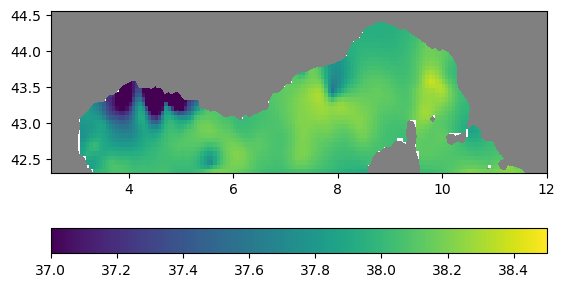

In [11]:
pcolor(xi,yi,fi.+mean(obsval),vmin=37,vmax=38.5);
colorbar(orientation="horizontal")
contourf(bx,by,copy(b'), levels = [-1e5,0],colors = [[.5,.5,.5]])
aspectratio = 1/cos(mean([ylim()...]) * pi/180)
gca().set_aspect(aspectratio)

## Exact error and approximations

Details can be found in the publication:

Approximate and Efficient Methods to Assess Error Fields in Spatial Gridding with Data Interpolating Variational Analysis (DIVA) Beckers, Jean-Marie; Barth, Alexander;  Troupin, Charles, Alvera-Azcarate, A.  *Journal of Atmospheric & Oceanic Technology* (2014), **31(2)**, 515-530     
https://orbi.uliege.be/handle/2268/161069      
https://journals.ametsoc.org/doi/abs/10.1175/JTECH-D-13-00130.1

In the 2D case you can try to calculate the exact error expression. This demands the computationally expensive evaluation of `diag(s.P)` accessible via the analysis returned structure `s`. This is only available with `DIVAndrun`.

In [12]:
# plots the error field `exerr`
function ploterr(exerr; vmin=0, vmax=1.5, cmap="hot_r")
    pcolor(xi,yi,exerr,vmin=vmin, vmax=vmax, cmap=cmap);
    colorbar(orientation="horizontal")
    contourf(bx,by,copy(b'), levels = [-1e5,0],colors = [[.5,.5,.5]])
    plot(obslon, obslat, "k.", markersize=.5)
    ylim(extrema(yi))
    gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))
end

ploterr (generic function with 1 method)

### Exact error by hand

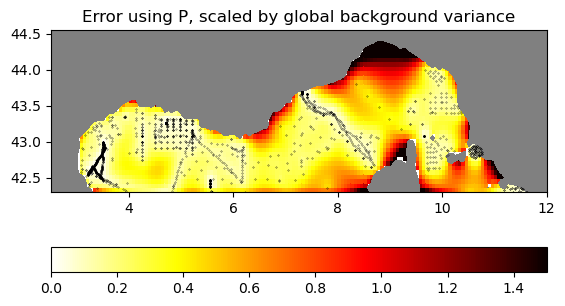

In [13]:
exerr, = statevector_unpack(s.sv,diag(s.P),NaN)
ploterr(exerr)
title("Error using P, scaled by global background variance");

### Exact error as a choice via the errormap function

In [14]:
aerrora,method = DIVAnd_errormap(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2,
    s;
    method = "exact",
    Bscale = false)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], "exact")

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


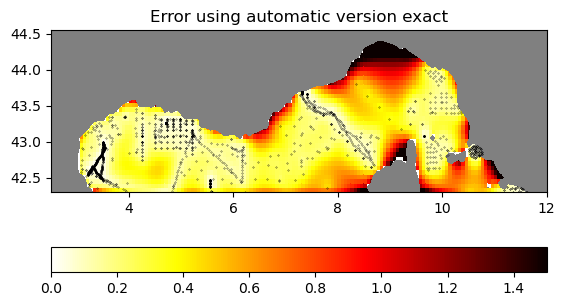

In [16]:
ploterr(aerrora)
title("Error using automatic version $method");

# Other options

## Precise version, actual method chosen will depend upen data coverage

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


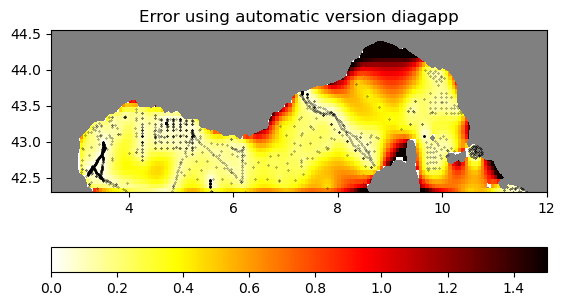

In [17]:
aerror,method = DIVAnd_errormap(mask,(pm,pn),(xi,yi),(obslon,obslat),obsval.-mean(obsval),len,epsilon2,
    s;
    method = :precise,
    Bscale = false)
ploterr(aerror)
title("Error using automatic version $method");

### Other options for method are `:auto`, `:cheap`, `:precise`, `:cpme`, `:scpme`, `:exact`, `:aexerr`, `:diagapp`


## Difference between error fields
We also overlay the data positions.

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


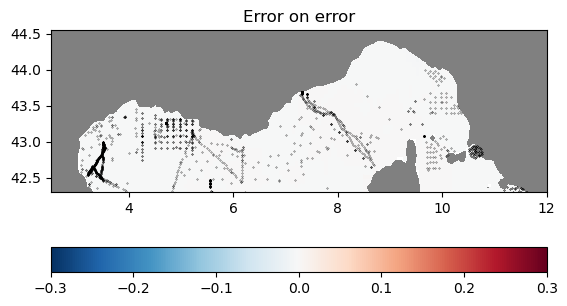

In [18]:
ploterr(aerror-exerr,vmin=-0.3, vmax=0.3, cmap="RdBu_r")
title("Error on error");

## How to plot standart deviations ?

Error fields shown above are error variance divided by a global background error variance $\sigma^2$. The latter is difficult to assess but a simple practical way is to use data variance VAR and split it into background error variance $\sigma^2$ and observational error variance $\epsilon^2$, assuming the $epsilon2$ value is correct (epsilon2 is the parameter used in DIVAndrun and is the relative observational error variance). VAR is the total variance of your data.

$epsilon2$ = ${ \epsilon^2 \over \sigma^2 } $

$ \epsilon^2 + \sigma^2 $ = VAR

Provides

$\sigma^2$= $ {1 \over 1 + epsilon2 }$ VAR

$\epsilon^2$= $ {epsilon2 \over 1 + epsilon2 }$ VAR


If you are not sure about the value of $epsilon2$ you might consider using DIVAnd_adaptedeps2(s, fi) 

In [28]:
epsilon2=DIVAnd_adaptedeps2(s, fi)
VAR=var(obsval)
eps2=epsilon2/(1.0+epsilon2)*VAR
sig2=1.0/(1.0+epsilon2)*VAR
@show eps2,sig2,eps2+sig2,VAR,eps2/sig2,epsilon2

(eps2, sig2, eps2 + sig2, VAR, eps2 / sig2, epsilon2) = (0.5582853741586363, 0.43206132550097254, 0.9903466996596089, 0.9903466996596086, 1.2921438259055187, 1.2921438259055187)


(0.5582853741586363, 0.43206132550097254, 0.9903466996596089, 0.9903466996596086, 1.2921438259055187, 1.2921438259055187)

sys:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


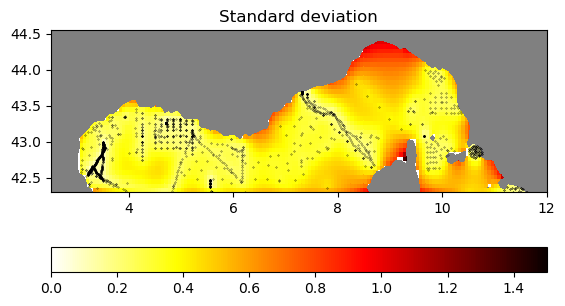

In [29]:
myabserror=sqrt.(sig2.*exerr)
ploterr(myabserror)
title("Standard deviation");

## How to calculate error on average fields

In [50]:
# if uniform grid is assumed
gridsurf=ones(Float64,size(s.P)[1],1)
volumes=ones(Float64,size(fi))

# for non-uniform grids, you need to calculate "volumes/surfaces" of each grid box for integration
function volint(mask, pmn)
 NDIM = ndims(mask)
    dim = size(mask)
    # volume based on metrics
    volume = zeros(Float64, dim)
    volume[mask] .= 1.0
    for i = 1:NDIM
        volume .= volume ./ pmn[i]
    end
    return volume
end
# now put volumes from grid into statevector space

volumes=volint(mask,(pm,pn))
gridsurf=statevector_pack(s.sv,(volumes,))
gridsurf=reshape(gridsurf, length(gridsurf), 1)

#Now you have an array of surface in state-space which can be used to integrate

erronmean=diagMtCM(s.P,gridsurf)[1]/((sum(gridsurf))^2)
# That is the error variance of the mean, still scaled by the background error variance (no units)






0.008069400205340393

In [40]:

# now scale by estimate of $\sigma^2$ and take square root

myabserror=sqrt(sig2*erronmean)


0.05904638641540387

# Mean value of analysed anomalies

In [54]:
mfi=volumes.*fi
meanfi=sum(mfi[.!isnan.(fi)])/sum(volumes[.!isnan.(fi)])

0.16055271338921434

In [33]:
mean(obsval)

37.79835795576099

One sigma range:

In [55]:
[mean(obsval) + meanfi - myabserror, mean(obsval) + meanfi + myabserror]

2-element Vector{Float64}:
 37.899864282734804
 38.01795705556561

3.1180927728308077